In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

BATCH_SIZE = 256
LEARNING_RATE = 0.01
EPOCHS = 25
SPLIT_RATIO = 0.8

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"当前使用设备: {device}")
if device.type == 'cuda':
    print(f"GPU 型号: {torch.cuda.get_device_name(0)}")


当前使用设备: cuda
GPU 型号: NVIDIA GeForce RTX 4060 Laptop GPU


数据准备

In [38]:
transform = transforms.Compose([transforms.ToTensor()])

full_train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
val_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


train_size = int(SPLIT_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

print(f"正在划分数据集 (8:2)...")
print(f"训练集数量: {train_size}")
print(f"验证集数量: {val_size}")

# 3. 随机划分
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) # 设置随机种子，保证每次划分一致
)

# 4. 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


正在划分数据集 (8:2)...
训练集数量: 48000
验证集数量: 12000


模型定义

In [39]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            # Q1: 将平均池化更换为最大池化
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

model = LeNet().to(device)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

训练

In [40]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"开始训练 {EPOCHS} 轮...")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- 训练阶段 ---
    model.train()
    running_loss = 0.0

    # 内层进度条：显示当前 Epoch 的 Batch 进度
    # 使用 tqdm 包装 train_loader
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)

    for X, y in train_bar:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        # 实时更新进度条后缀，显示当前 batch 的 loss
        train_bar.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- 验证阶段 ---
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # 验证阶段通常很快，一般不需要复杂的进度条，但为了统一也可以加上
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            val_running_loss += loss.item() * X.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = correct / total

    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    # 每一轮结束后打印汇总信息 (tqdm 会自动处理换行)
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f} - "
          f"Val Loss: {epoch_val_loss:.4f} - "
          f"Val Acc: {epoch_val_acc:.4f}")

total_time = time.time() - start_time
print(f"训练结束。总耗时: {total_time:.2f} 秒")

开始训练 25 轮...


Epoch 1/25 - Train Loss: 1.4063 - Val Loss: 0.6816 - Val Acc: 0.7340


Epoch 2/25 - Train Loss: 0.5706 - Val Loss: 0.5049 - Val Acc: 0.8106


Epoch 3/25 - Train Loss: 0.4753 - Val Loss: 0.4480 - Val Acc: 0.8344


Epoch 4/25 - Train Loss: 0.4287 - Val Loss: 0.4426 - Val Acc: 0.8376


Epoch 5/25 - Train Loss: 0.3985 - Val Loss: 0.4161 - Val Acc: 0.8414


Epoch 6/25 - Train Loss: 0.3782 - Val Loss: 0.3789 - Val Acc: 0.8596


Epoch 7/25 - Train Loss: 0.3598 - Val Loss: 0.3741 - Val Acc: 0.8582


Epoch 8/25 - Train Loss: 0.3471 - Val Loss: 0.3713 - Val Acc: 0.8592


Epoch 9/25 - Train Loss: 0.3332 - Val Loss: 0.3564 - Val Acc: 0.8669


Epoch 10/25 - Train Loss: 0.3263 - Val Loss: 0.3591 - Val Acc: 0.8677


Epoch 11/25 - Train Loss: 0.3172 - Val Loss: 0.3429 - Val Acc: 0.8754


Epoch 12/25 - Train Loss: 0.3109 - Val Loss: 0.3431 - Val Acc: 0.8745


Epoch 13/25 - Train Loss: 0.3029 - Val Loss: 0.3295 - Val Acc: 0.8794


Epoch 14/25 - Train Loss: 0.2937 - Val Loss: 0.3455 - Val Acc: 0.8705


Epoch 15/25 - Train Loss: 0.2939 - Val Loss: 0.3145 - Val Acc: 0.8846


Epoch 16/25 - Train Loss: 0.2797 - Val Loss: 0.3160 - Val Acc: 0.8808


Epoch 17/25 - Train Loss: 0.2739 - Val Loss: 0.3507 - Val Acc: 0.8712


Epoch 18/25 - Train Loss: 0.2788 - Val Loss: 0.3345 - Val Acc: 0.8761


Epoch 19/25 - Train Loss: 0.2669 - Val Loss: 0.3265 - Val Acc: 0.8763


Epoch 20/25 - Train Loss: 0.2611 - Val Loss: 0.3127 - Val Acc: 0.8851


Epoch 21/25 - Train Loss: 0.2583 - Val Loss: 0.3110 - Val Acc: 0.8855


Epoch 22/25 - Train Loss: 0.2542 - Val Loss: 0.3130 - Val Acc: 0.8852


Epoch 23/25 - Train Loss: 0.2497 - Val Loss: 0.3242 - Val Acc: 0.8835


Epoch 24/25 - Train Loss: 0.2443 - Val Loss: 0.3355 - Val Acc: 0.8812


Epoch 25/25 - Train Loss: 0.2419 - Val Loss: 0.3125 - Val Acc: 0.8866
训练结束。总耗时: 122.58 秒


绘制结果

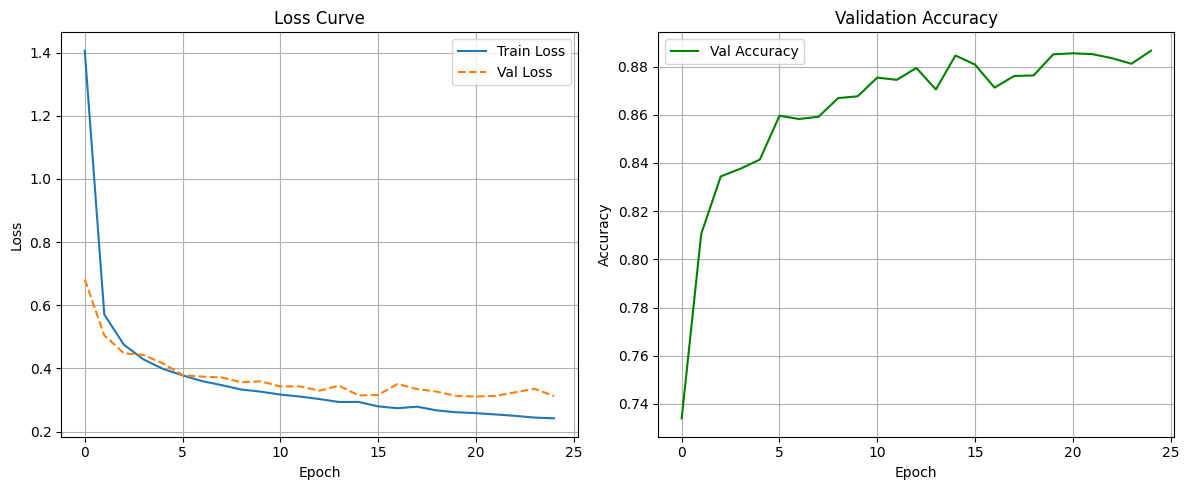

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
